In [95]:
# Dependencies
# !pip install "calcbench-api-client[Pandas, Backoff, BeautifulSoup]" tqdm scipy seaborn

In [92]:
import pandas as pd

from tqdm.notebook import tqdm
import qgrid

from scipy.special import expit
import seaborn as sns

import calcbench as cb


cb.enable_backoff()
tqdm.pandas(desc="progress")

In [94]:
disclosure_embeddings = pd.read_pickle(
    r"C:\Users\andre\Dropbox (Calcbench)\andrew\sp_500_tokenize_embeddings.pkl"
)

In [11]:
def distance(word_counts: Counter, category_words: Iterable[str]):
    return sum(count for word, count in word_counts.items() if word in category_words)

In [12]:
category_distances = disclosure_embeddings.progress_applymap(
    lambda word_counts: distance(word_counts, ["inflation"])
)

progress:   0%|          | 0/14940 [00:00<?, ?it/s]

In [18]:
profit_margin = cb.standardized_data(
    company_identifiers=cb.tickers(index="SP500"),
    metrics=["GrossProfitMargin"],
    all_history=True,
    period_type="annual",
)["GrossProfitMargin"]

In [ ]:
md_a_diff = (
    category_distances.ManagementsDiscussionAndAnalysis
    - category_distances.ManagementsDiscussionAndAnalysis.shift()
)

In [79]:
profig_margin_change = profit_margin - profit_margin.shift()

In [82]:
d = (
    pd.DataFrame(
        data={
            "profit_margin_change": expit(profig_margin_change.stack()),
            "inflation_count_change": expit(md_a_diff).stack(),
        }
    )
    .swaplevel()
    .sort_index()
)

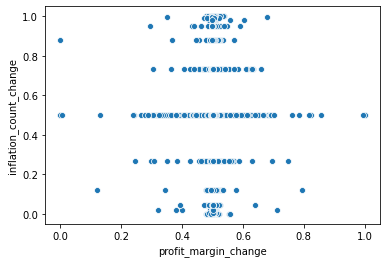

In [93]:
sns.scatterplot(x="profit_margin_change", y="inflation_count_change", data=d)